# Import Libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# Load the Dataset

In [21]:
df = pd.read_csv("C:/Users/harsh/OneDrive/Desktop/Unified Mentor/TCS_stock_history.csv")  
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()


Date       Open       High        Low      Close  Volume  Dividends  \
0 2002-08-12  28.794172  29.742206  28.794172  29.519140  212976        0.0   
1 2002-08-13  29.556316  30.030333  28.905705  29.119476  153576        0.0   
2 2002-08-14  29.184536  29.184536  26.563503  27.111877  822776        0.0   
3 2002-08-15  27.111877  27.111877  27.111877  27.111877       0        0.0   
4 2002-08-16  26.972458  28.255089  26.582090  27.046812  811856        0.0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0

# Data Preprocessing

In [12]:
# Check for null values
print(df.isnull().sum())

# Convert numeric columns (in case of string formatting issues)
cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Forward-fill missing values
df.fillna(method='ffill', inplace=True)


Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


# Exploratory Data Analysis (EDA)

1. Plotting Close Price Over Time

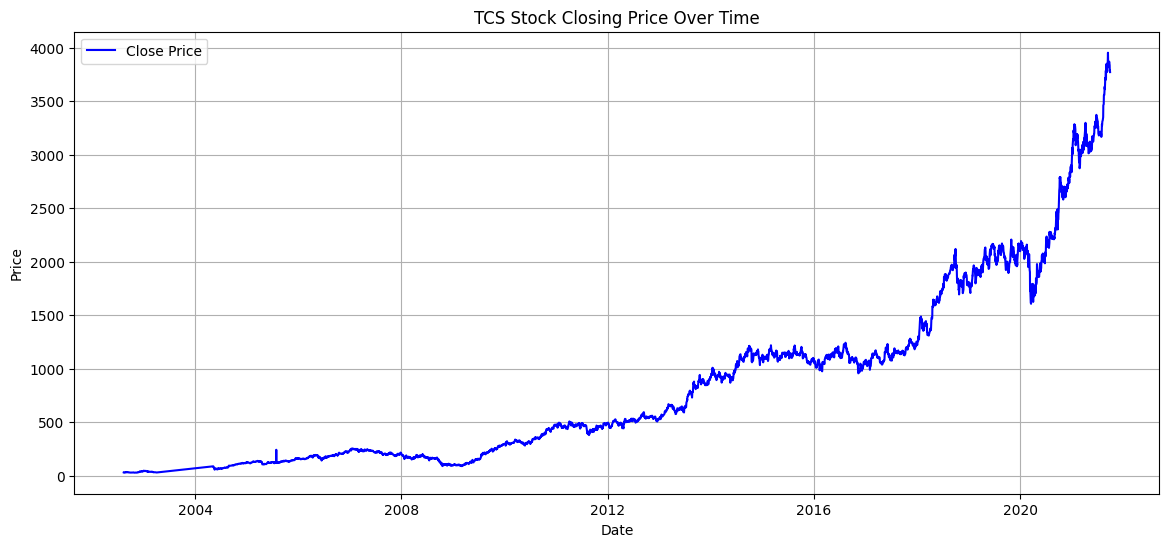

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='blue')
plt.title('TCS Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


2. Plotting Volume, Dividends, Stock Splits

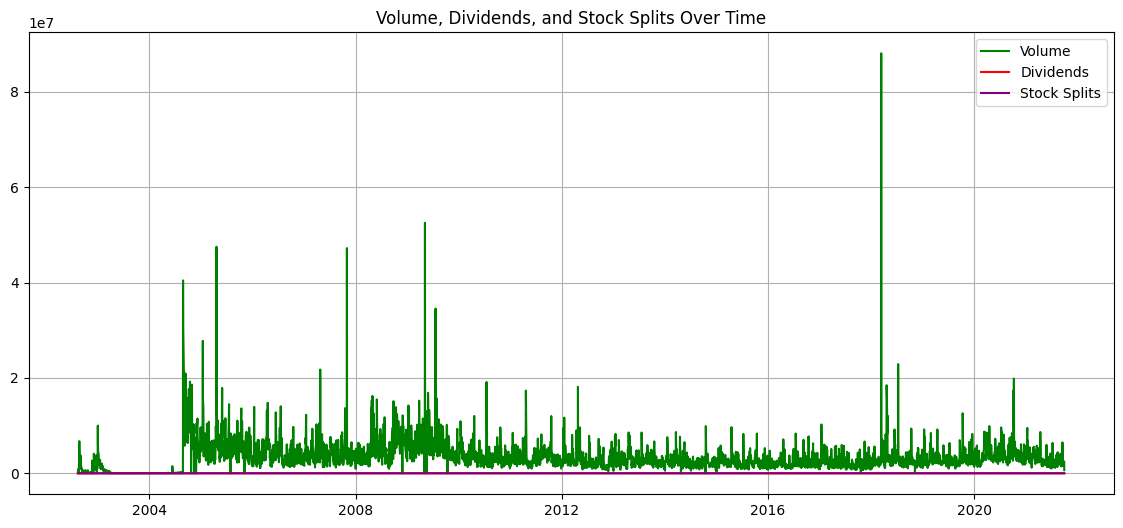

In [14]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Volume'], label='Volume', color='green')
plt.plot(df['Date'], df['Dividends'], label='Dividends', color='red')
plt.plot(df['Date'], df['Stock Splits'], label='Stock Splits', color='purple')
plt.title('Volume, Dividends, and Stock Splits Over Time')
plt.legend()
plt.grid()
plt.show()


3. Moving Averages

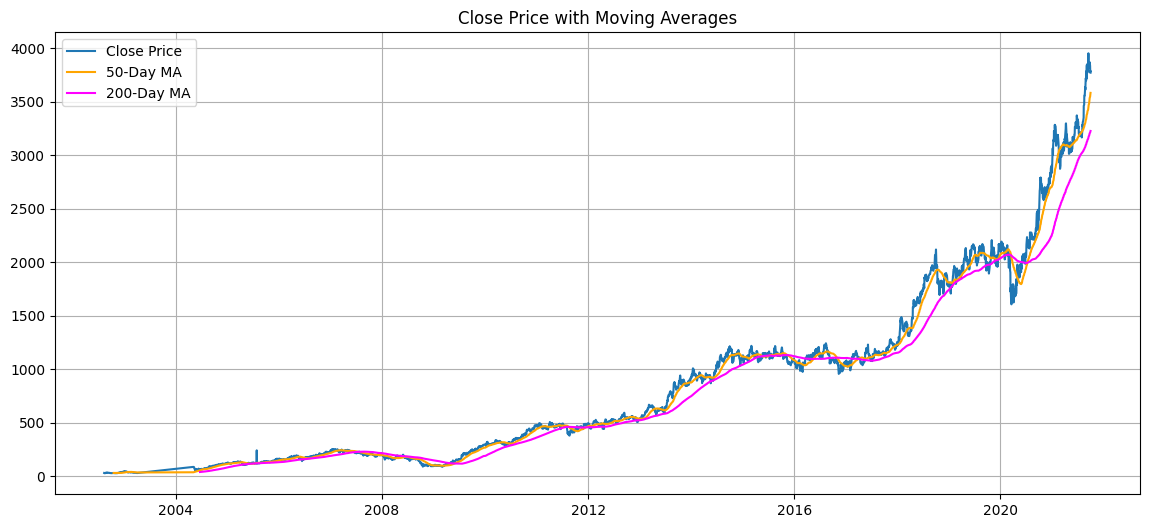

In [15]:
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['MA50'], label='50-Day MA', color='orange')
plt.plot(df['Date'], df['MA200'], label='200-Day MA', color='magenta')
plt.title('Close Price with Moving Averages')
plt.legend()
plt.grid()
plt.show()


# Feature Engineering

In [16]:
# Time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Day_of_Week'] = df['Date'].dt.dayofweek

# Lag features
df['Prev_Close'] = df['Close'].shift(1)
df.dropna(inplace=True)  # Drop NA after shifting


# Linear Regression Model for Prediction

In [17]:
features = ['Open', 'High', 'Low', 'Volume', 'Prev_Close', 'Day_of_Week', 'Month']
target = 'Close'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Prediction
y_pred = lr_model.predict(X_test)

# Evaluation
print("Linear Regression MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


Linear Regression MSE: 39.04992998516231
R² Score: 0.9999438356582193


# Visualizing Linear Regression Results

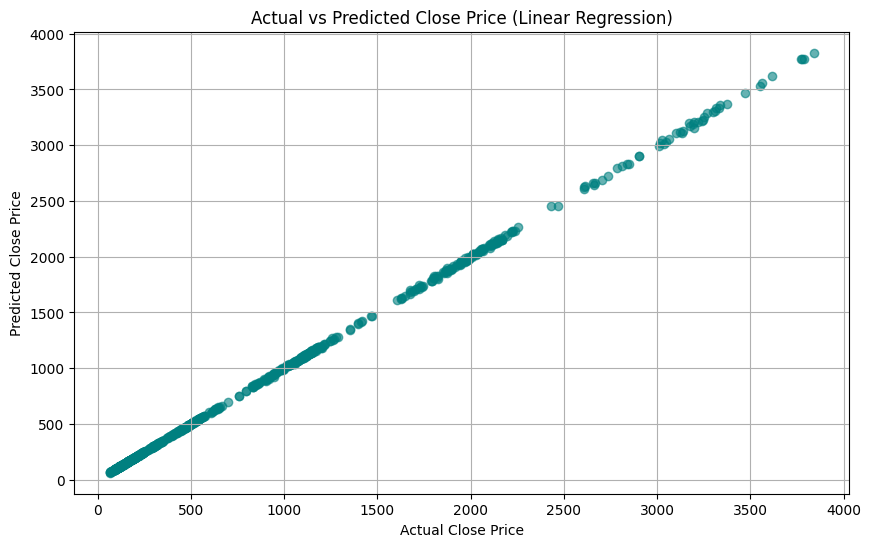

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='teal')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted Close Price (Linear Regression)')
plt.grid()
plt.show()


# LSTM Model for Time-Series Prediction

1. Data Preparation

In [19]:
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(df[['Close']])

# Create training and testing data
X_lstm = close_scaled[:-1]
y_lstm = close_scaled[1:]

X_lstm = X_lstm.reshape(-1, 1, 1)  # [samples, time steps, features]


2. Building and Training the LSTM Model

In [22]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, input_shape=(1, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Training
for epoch in tqdm(range(30), desc="Training LSTM"):
    for i in range(0, len(X_lstm), 15):
        X_batch = X_lstm[i:i+15]
        y_batch = y_lstm[i:i+15]
        lstm_model.train_on_batch(X_batch, y_batch)


Training LSTM: 100%|███████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.41it/s]


3. Making Predictions

In [23]:
test_data = df[-len(X_lstm):]['Close'].values.reshape(-1, 1)
test_scaled = scaler.transform(test_data)
test_scaled = test_scaled.reshape(-1, 1, 1)

lstm_predictions = lstm_model.predict(test_scaled).flatten()
lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1)).flatten()


134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


4. Visualization

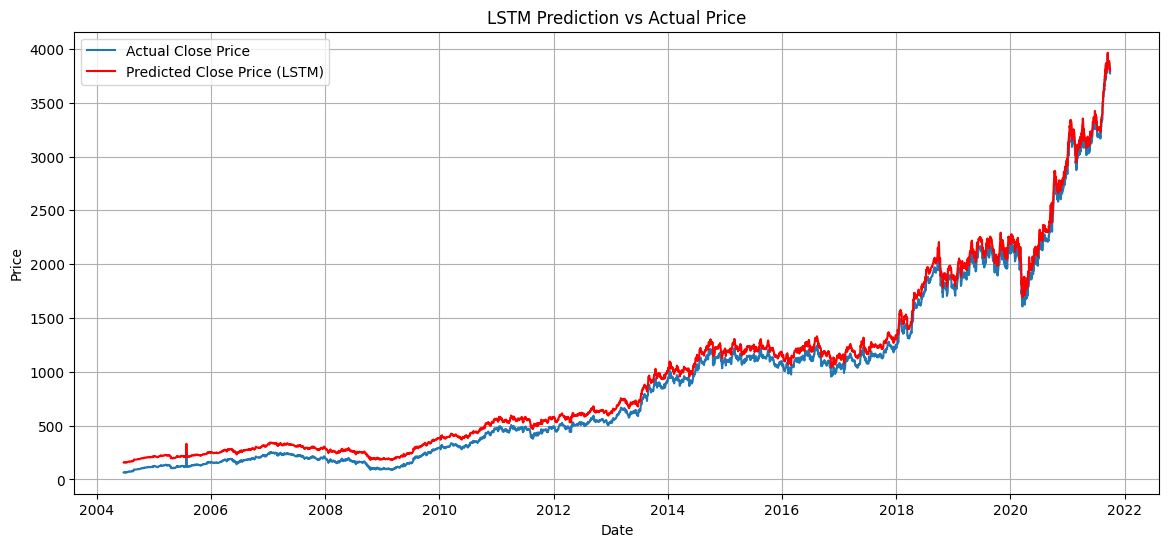

In [24]:
plt.figure(figsize=(14, 6))
plt.plot(df['Date'][-len(lstm_predictions):], test_data.flatten(), label='Actual Close Price')
plt.plot(df['Date'][-len(lstm_predictions):], lstm_predictions, label='Predicted Close Price (LSTM)', color='red')
plt.title('LSTM Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


# Dashboard (interactive cells)

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Page Config
st.set_page_config(page_title="TCS Stock Dashboard", layout="wide")

# Title
st.title("📈 TCS Stock Data - Live & Historical Dashboard")

# Sidebar: Upload CSV or use default
st.sidebar.header("📂 Upload Data")
uploaded_file = st.sidebar.file_uploader("Upload your CSV file", type=["csv"])

@st.cache_data
def load_data(file):
    df = pd.read_csv(file)
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df['MA30'] = df['Close'].rolling(window=30).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['MA200'] = df['Close'].rolling(window=200).mean()
    return df

if uploaded_file:
    df = load_data(uploaded_file)
else:
    df = load_data("TCS_stock_history.csv")  # Make sure this file is in the same folder

# Sidebar: Date filter
st.sidebar.subheader("📅 Date Range Filter")
min_date, max_date = df['Date'].min(), df['Date'].max()
start_date = st.sidebar.date_input("Start Date", min_value=min_date, max_value=max_date, value=min_date)
end_date = st.sidebar.date_input("End Date", min_value=min_date, max_value=max_date, value=max_date)

# Filter data by selected date range
filtered_df = df[(df['Date'] >= pd.to_datetime(start_date)) & (df['Date'] <= pd.to_datetime(end_date))]

# Tabs
tab1, tab2, tab3 = st.tabs(["📊 Stock Trends", "📉 Volume & Splits", "🤖 Predict Close Price"])

# === TAB 1 ===
with tab1:
    st.subheader("📊 TCS Close Price & Moving Averages")
    st.line_chart(filtered_df.set_index('Date')[['Close', 'MA30', 'MA50', 'MA200']])

# === TAB 2 ===
with tab2:
    st.subheader("📉 Volume, Dividends & Stock Splits")
    
    st.area_chart(filtered_df.set_index('Date')[['Volume']])
    col1, col2 = st.columns(2)
    with col1:
        st.bar_chart(filtered_df.set_index('Date')[['Dividends']])
    with col2:
        st.bar_chart(filtered_df.set_index('Date')[['Stock Splits']])

# === TAB 3 ===
with tab3:
    st.subheader("🤖 Linear Regression: Close Price Prediction")

    # Feature engineering
    temp_df = filtered_df.copy()
    temp_df['Prev_Close'] = temp_df['Close'].shift(1)
    temp_df.dropna(inplace=True)

    features = ['Open', 'High', 'Low', 'Volume', 'Prev_Close']
    X = temp_df[features]
    y = temp_df['Close']

    # Train/Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    st.write("📌 **Model Evaluation**")
    st.metric("R² Score", f"{r2:.4f}")
    st.metric("MSE", f"{mse:.2f}")

    # Plot prediction vs actual
    result_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
    st.line_chart(result_df.reset_index(drop=True))
